# Compare methods using Hagai data

In [45]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
%autoreload 2


In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import functools
import numpy as np
import logging
import scanpy as sc
import pickle as pkl
import statsmodels.api as sm
from joblib import Parallel, delayed
from functools import partial
import sklearn.linear_model as lm

pd.set_option('display.max_rows', 100)

In [65]:
data_path = '/data_volume/bulkrna/hagai/'

In [66]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
# plt.rcParams["axes.prop_cycle"] = plt.cycler("color", ['turquoise', 'slategrey', 'silver'])

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

### Functions for replication rate and false positive rate

In [78]:
datasets = [
    'Hagai2018_mouse-lps',
    'Hagai2018_mouse-pic',
    'Hagai2018_pig-lps',
    'Hagai2018_rabbit-lps',
    'Hagai2018_rat-lps',
    'Hagai2018_rat-pic',
]

bulk_methods = [
    ('deseq2_lrt',['log2FoldChange', 'pvalue', 'padj']),
    ('deseq2_wald',['log2FoldChange', 'pvalue', 'padj']),
    ('edger_lrt',['logFC', 'PValue', 'FDR']),
    ('edger_qlft',['logFC', 'PValue', 'FDR']),
]

sc_methods = [ 
    # ('quasiML',['coef', 'pval', 'fdr']),
    ('quasiGLM',['coef', 'pval', 'fdr']),
    ('edger_lrt',['logFC', 'PValue', 'FDR']),
    ('edger_qlft',['logFC', 'PValue', 'FDR']),
    ('deseq2_wald',['log2FoldChange', 'pvalue', 'padj']),
    ('deseq2_lrt',['log2FoldChange', 'pvalue', 'padj']),

    # ('MAST', ['coef', 'Pr(>Chisq)','fdr']),
    ('t',['coef', 'pval', 'fdr']),
    ('MWU',['coef', 'pval', 'fdr']),
]

In [90]:
def read_bulk_dataset(dataset, method, cols):
    
    df = pd.read_csv(data_path + 'bulk_rnaseq/results/{}_{}.csv'.format(dataset, method), index_col=0)[cols]
    df.columns = ['coef','pval', 'fdr']
    # df.index = df['gene']
    return df

def read_sc_dataset(dataset, method, cols):
    
    df = pd.read_csv(data_path +  'sc_rnaseq/results/{}_{}.csv'.format(dataset, method), index_col=0)[cols]
    df.columns = ['coef','pval', 'fdr']
    
    # if method == 'memento':
    #     df['fdr'] = -df['coef'].abs()
    # # df.index = df['gene']
    return df

def read_sampled_dataset(dataset, method, cols):
    
    df = pd.read_csv(data_path +  'sc_rnaseq/results/{}_100_{}.csv'.format(dataset, method), index_col=0)[cols]
    df.columns = ['coef','pval', 'fdr']
    # df.index = df['gene']
    return df

def concordance_auc(refs, x, k=5):
    count = 0
    for i in range(1, k+1):
        
        ref_total = 0
        for ref in refs:
            ref_total += len(set(x[:i]) & set(ref[:i]))
            
        count += ref_total/len(refs)
        
    return count / (k*(k+1)/2)

all_results = []
small_results = []
for dataset in datasets:
    
    print(dataset)
    condition = dataset.split('-')[-1] + '4'
    
    dispersion = pd.read_csv(data_path + f'sc_rnaseq/results/{dataset}_dispersions.csv', index_col=0)
    dispersion = dispersion.set_index('gene')
    
    bulk_results = [read_bulk_dataset(dataset, method, cols) for method, cols in bulk_methods]
    sc_results = [read_sc_dataset(dataset, method, cols) for method, cols in sc_methods]
    sampled_results = [read_sampled_dataset(dataset, method, cols) for method, cols in sc_methods]

    gene_list = [set(res.index) for res in sc_results] + [set(res.index) for res in bulk_results] + [set(res.index) for res in sampled_results]
    genes = list(functools.reduce(lambda x,y: x & y, gene_list))

    bulk_results = [res.loc[genes].sort_values('fdr') for res in bulk_results]
    sc_results = [res.loc[genes].sort_values('fdr') for res in sc_results]
    sampled_results = [res.loc[genes].sort_values('fdr') for res in sampled_results]


    scores = [(sc_methods[idx][0], dataset, concordance_auc([b_res.index for b_res in bulk_results], res.index, k=100)) for idx, res in enumerate(sc_results)]
    # sampled_scores = [(sc_methods[idx][0], dataset, concordance_auc([b_res.index for b_res in bulk_results], res.index, k=100)) for idx, res in enumerate(sampled_results)]
    all_results+=scores
    # small_results += sampled_scores
    
    
    # print(dispersion.mean())
    

Hagai2018_mouse-lps
Hagai2018_mouse-pic
Hagai2018_pig-lps
Hagai2018_rabbit-lps
Hagai2018_rat-lps
Hagai2018_rat-pic


In [91]:
df = pd.DataFrame(all_results, columns=['name', 'dataset', 'auc'])
# small_df = pd.DataFrame(small_results, columns=['name', 'dataset', 'auc'])

In [92]:
df

,name,dataset,auc
0,quasiGLM,Hagai2018_mouse-lps,0.494950
1,edger_lrt,Hagai2018_mouse-lps,0.579703
2,edger_qlft,Hagai2018_mouse-lps,0.533713
3,deseq2_wald,Hagai2018_mouse-lps,0.582228
4,deseq2_lrt,Hagai2018_mouse-lps,0.562970
5,t,Hagai2018_mouse-lps,0.118515
6,MWU,Hagai2018_mouse-lps,0.135644
7,quasiGLM,Hagai2018_mouse-pic,0.296436
8,edger_lrt,Hagai2018_mouse-pic,0.381139
9,edger_qlft,Hagai2018_mouse-pic,0.025495


<Axes: xlabel='auc', ylabel='name'>

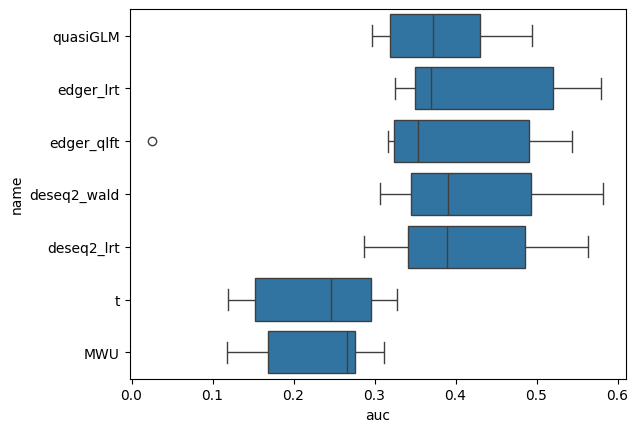

In [93]:
sns.boxplot(y='name', x='auc', data=df)


In [94]:
df_cano = pd.read_csv('cano.csv')
# small_df_cano = pd.read_csv('../canogamez/small_cano.csv')

In [95]:
combined = pd.concat([df, df_cano]).replace('quasiGLM', 'memento')
# small_combined = pd.concat([small_df, small_df_cano]).replace('quasiGLM', 'memento')

# combined['cell count'] = 'all'
# small_combined['cell count']= '100'

In [96]:
# merged = pd.concat([combined, small_combined])

In [97]:
# plt.figure(figsize=(3, 4))
# sns.boxplot(y='name', x='auc', hue='cell count', data=merged)
# # sns.stripplot(y='name', x='auc', hue='cell count', data=merged, color='grey')
# plt.title('Bulk RNA-seq comparison')

2025-01-03 00:28:42 234489  WARNING  /tmp/ipykernel_234489/2277811074.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='name', x='auc', data=combined, palette=my_pal)



Text(0.5, 1.0, 'Squair et al. comparisons')

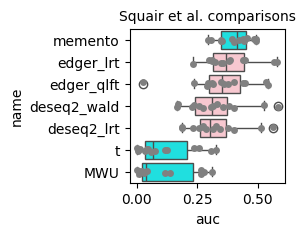

In [98]:
plt.figure(figsize=(2, 2))
my_pal = {
    "memento": "cyan", 
    "quasiML": 'red',
    "edger_lrt": "pink", 
    "edger_qlft":"pink",
    "deseq2_wald":"pink",
    "deseq2_lrt":"pink",
    "t":"cyan",
    "MWU":"cyan"
}
sns.boxplot(y='name', x='auc', data=combined, palette=my_pal)
sns.stripplot(y='name', x='auc', data=combined, color='grey')
plt.title('Squair et al. comparisons')
# plt.savefig('squair_comparison.pdf', bbox_inches='tight')

In [99]:
plt.figure(figsize=(3, 2))

sns.boxplot(y='name', x='auc', data=small_combined)
sns.stripplot(y='name', x='auc', data=small_combined, color='grey')
plt.title('Bulk RNA-seq comparison using 100 cells')

NameError: name 'small_combined' is not defined

<Figure size 300x200 with 0 Axes>

# Scratch

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import functools
import numpy as np
import scanpy as sc
import logging
import scipy.stats as stats
from statsmodels.stats.multitest import fdrcorrection
from patsy import dmatrix, dmatrices 
import statsmodels.api as sm
import os

import sys
sys.path.append('/home/ubuntu/Github/scrna-parameter-estimation/')

import memento

logging.basicConfig(
    format="%(asctime)s %(process)-7s %(levelname)-8s %(message)s",
    level=logging.INFO, 
    datefmt="%Y-%m-%d %H:%M:%S",
)
logging.captureWarnings(True)

data_path = '/data_volume/bulkrna/hagai/sc_rnaseq/'

columns = ['coef', 'pval', 'fdr']

In [59]:
files = [
    'Hagai2018_mouse-lps',
    'Hagai2018_mouse-pic',
    'Hagai2018_pig-lps',
    'Hagai2018_rabbit-lps',
    'Hagai2018_rat-lps',
    'Hagai2018_rat-pic',
]

def safe_fdr(x):
    fdr = np.ones(x.shape[0])
    _, fdr[np.isfinite(x)] = fdrcorrection(x[np.isfinite(x)])
    return fdr
    
for file in files:

    condition = file.split('-')[-1] + '4'

    adata = sc.read_h5ad(data_path +'h5Seurat/' + file + '.h5ad')

    gene_list = adata.var.index[adata.X.mean(axis=0).A1 > 0.02].tolist()

    adata.obs['q'] = 0.07
    memento.setup_memento(
        adata, 
        'q', 
        filter_mean_thresh=0.02, 
        estimator_type='pseudobulk')

    memento.create_groups(adata, label_columns=['replicate', 'label'])

    memento.compute_1d_moments(adata, min_perc_group=0, gene_list=gene_list)

    condition = 'unst'
    df = pd.DataFrame(index=adata.uns['memento']['groups'])
    df['mouse'] = df.index.str.split('^').str[1]
    df['stim'] = df.index.str.split('^').str[2]
    cov_df = pd.get_dummies(df[['mouse']], drop_first=True).astype(float)
    stim_df = (df[['stim']]==condition).astype(float)
    cov_df = sm.add_constant(cov_df)
    cov_df = cov_df#[['const']]

    memento.ht_mean(
        adata=adata, 
        treatment=stim_df,
        covariate=cov_df,
        treatment_for_gene=None,
        covariate_for_gene=None,
        inplace=True, 
        num_boot=2000, 
        verbose=1,
        num_cpus=14)

    results = memento.get_mean_ht_result(adata)
    results.columns = ['gene', 'tx', 'coef', 'se', 'pval'] # for standardization purposes
    results.set_index('gene', inplace=True)
    results['fdr'] = memento.util._fdrcorrect(results['pval'])
    results.to_csv(data_path + f'results/{file}_quasiML.csv')            


2025-01-02 21:42:26 234489  INFO     Differential mean expression in quasiML mode.
2025-01-02 21:42:28 234489  INFO     Computing statistics for differential mean
[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.2s
[Parallel(n_jobs=14)]: Done 316 tasks      | elapsed:    2.4s
[Parallel(n_jobs=14)]: Done 816 tasks      | elapsed:    6.8s
[Parallel(n_jobs=14)]: Done 1516 tasks      | elapsed:   12.9s
[Parallel(n_jobs=14)]: Done 2416 tasks      | elapsed:   20.8s
[Parallel(n_jobs=14)]: Done 3516 tasks      | elapsed:   29.8s
[Parallel(n_jobs=14)]: Done 4816 tasks      | elapsed:   40.6s
[Parallel(n_jobs=14)]: Done 6316 tasks      | elapsed:   52.7s
[Parallel(n_jobs=14)]: Done 8016 tasks      | elapsed:  1.1min
[Parallel(n_jobs=14)]: Done 9408 out of 9408 | elapsed:  1.3min finished
[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | e